# Description

* `spark.ml`
    * newer API based on DataFrames
----    
* `spark.mllib` (DON'T USE ME)
    * original ML API based on RDD API


Data used in this notebook is from SF housing data set from Inside Airbnb.

`dev/github-bv/LearningSparkV2/databricks-datasets/learning-spark-v2/sf-airbnb`

# Setup

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports

In [3]:
import os
import os.path as path

# Spark

In [11]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = (SparkSession
         .builder
         .master('local[*]')
         .appName("spark-ml-ch-10b")
         .config('ui.showConsoleProgress', 'false')
         .getOrCreate())

# Functions

In [4]:
def db_fname(fname):
    import os.path as path
    data_dir = '~/dev/github-bv/LearningSparkV2/databricks-datasets/learning-spark-v2/'
    return path.expanduser(path.join(data_dir, fname))

# Designing ML Pipelines

* Pipeline API provides a high-level API built on top of DataFrames to organize ML worlflow
* composed of a series of `transformers` and `estimators`

## Definitions

* Transformer
    * DF -> DF + 1 or more columns appended
    * has `.transform()` method
* Estimator
    * DF -> Model (Transformer)
    * learns ('fits') params
    * has `.fit()` method
* Pipeline
    * organize a series of transformers and estimators into a single model
    * Pipeline is an `estimator`
    * `pipeline.fit()` returns a `PipelineModel`, which is a `transformer`
* Model
    * a Transformer which will return predictions

## Data Ingestion and Exploration

They've done some cleansing already. See Databricks communitiy edition notebook

In [8]:
filePath = db_fname('sf-airbnb/sf-airbnb-clean.parquet')

In [12]:
airbnbDF = spark.read.parquet(filePath)

In [13]:
airbnbDF.select('neighbourhood_cleansed', 'room_type', 'bedrooms', 'bathrooms', 'number_of_reviews', 'price').show(5)

+----------------------+---------------+--------+---------+-----------------+-----+
|neighbourhood_cleansed|      room_type|bedrooms|bathrooms|number_of_reviews|price|
+----------------------+---------------+--------+---------+-----------------+-----+
|      Western Addition|Entire home/apt|     1.0|      1.0|            180.0|170.0|
|        Bernal Heights|Entire home/apt|     2.0|      1.0|            111.0|235.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|             17.0| 65.0|
|        Haight Ashbury|   Private room|     1.0|      4.0|              8.0| 65.0|
|      Western Addition|Entire home/apt|     2.0|      1.5|             27.0|785.0|
+----------------------+---------------+--------+---------+-----------------+-----+
only showing top 5 rows



In [15]:
trainDF, testDF = airbnbDF.randomSplit([0.8, 0.2], seed=42)
print(f"""There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set""")

There are 5758 rows in the training set, and 1388 in the test set


## Preparing Features with Transformers

Linear regression (like many other algorithms in Spark) requires that **all the input features are contained within a single vector in your DataFrame**. Thus, we need to transform our data

Use `VectorAssembler` to combine all columns into a single vector. https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler

In [17]:
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols = ['bedrooms'], outputCol='features')
vecTrainDF = vecAssembler.transform(trainDF)
vecTrainDF.select('bedrooms','features', 'price').show(10)

+--------+--------+-----+
|bedrooms|features|price|
+--------+--------+-----+
|     1.0|   [1.0]|200.0|
|     1.0|   [1.0]|250.0|
|     3.0|   [3.0]|250.0|
|     1.0|   [1.0]| 45.0|
|     1.0|   [1.0]|115.0|
|     1.0|   [1.0]| 70.0|
|     1.0|   [1.0]|105.0|
|     1.0|   [1.0]| 86.0|
|     1.0|   [1.0]|100.0|
|     2.0|   [2.0]|220.0|
+--------+--------+-----+
only showing top 10 rows



In [20]:
vecAssembler.getInputCols()

['bedrooms']

In [21]:
vecAssembler.getOutputCol()

'features'

## Using Estimators to Build Models

In [26]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='price')
lrModel = lr.fit(vecTrainDF)

In [27]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

In [29]:
type(lr)

pyspark.ml.regression.LinearRegression

`lr.fit()` returns a `LinearRegressionModel` (lrModel), which is a `transformer`. In other words, the **output** of an estimator’s `fit()` method is a `transformer`. Once the estimator has learned the parameters, the transformer can apply these parameters to new data points to generate predictions

In [31]:
m = round(lrModel.coefficients[0], 2)
b = round(lrModel.intercept,2)

print(f"""The formula for the linear regression line is  price = {m} x bedrooms + {b}""")

The formula for the linear regression line is  price = 119.32 x bedrooms + 54.11


In [32]:
lrModel.coefficients

DenseVector([119.3164])

In [36]:
mp = lrModel.extractParamMap()

In [37]:
mp

{Param(parent='LinearRegression_96b02464c14f', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LinearRegression_96b02464c14f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LinearRegression_96b02464c14f', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35,
 Param(parent='LinearRegression_96b02464c14f', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LinearRegression_96b02464c14f', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LinearRegression_96b02464c14f', name='labelCol', doc='label column name'): 'price',
 Param(parent='LinearRegression_96b02464c14f', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)'): 'squaredError',
 Param(pa

In [42]:
for m in mp:
    print(f'{m.name}: \t{mp[m]}')

aggregationDepth: 	2
elasticNetParam: 	0.0
epsilon: 	1.35
featuresCol: 	features
fitIntercept: 	True
labelCol: 	price
loss: 	squaredError
maxIter: 	100
predictionCol: 	prediction
regParam: 	0.0
solver: 	auto
standardization: 	True
tol: 	1e-06


## Creating a Pipeline

`pipelineModel` is a `transformer`

In [44]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)

Apply it to our test data set

In [45]:
preDF = pipelineModel.transform(testDF)

In [46]:
preDF.columns

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'host_total_listings_count',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price',
 'bedrooms_na',
 'bathrooms_na',
 'beds_na',
 'review_scores_rating_na',
 'review_scores_accuracy_na',
 'review_scores_cleanliness_na',
 'review_scores_checkin_na',
 'review_scores_communication_na',
 'review_scores_location_na',
 'review_scores_value_na',
 'features',
 'prediction']

In [47]:
preDF.select('bedrooms', 'features', 'price', 'prediction').show(10)

+--------+--------+-----+------------------+
|bedrooms|features|price|        prediction|
+--------+--------+-----+------------------+
|     1.0|   [1.0]|130.0|173.42588969100558|
|     1.0|   [1.0]| 85.0|173.42588969100558|
|     1.0|   [1.0]| 95.0|173.42588969100558|
|     1.0|   [1.0]|128.0|173.42588969100558|
|     1.0|   [1.0]|250.0|173.42588969100558|
|     1.0|   [1.0]| 95.0|173.42588969100558|
|     1.0|   [1.0]|105.0|173.42588969100558|
|     0.0|   [0.0]|125.0| 54.10946937938496|
|     3.0|   [3.0]|405.0|412.05873031424676|
|     1.0|   [1.0]| 72.0|173.42588969100558|
+--------+--------+-----+------------------+
only showing top 10 rows



## One-hot encoding

Convert categorical values into numeric values

Spark uses a `SparseVector` when the majority of entries are 0, so OHE does not massively increase consumption of memory or compute resources

Multiple ways to one-hot encode data in Spark

1. Use `StringIndexer` and `OneHotEncoder`

  * apply `StringIndexer` estimator to convert categorical values into category indices (ordered by label frequencies)
  * pass output to `OneHotEncoder` (`OneHotEncoderEstimator` for us, since we're using Spark 2.4.0)

In [64]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, OneHotEncoderEstimator

# categoricalCols = [field for (field, dataType) in trainDF.dtypes if dataType == 'string']
# indexOutputCols = [x + 'Index' for x in categoricalCols]
# oheOutputCols = [x + 'OHE' for x in categoricalCols]

# stringIndexer = StringIndexer(inputCols=categoricalCols,
#                               outputCols=indexOutputCols,
#                               handleInvalid='skip')
# oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
#                            outputCols=oheOutputCols)

In [65]:
cat_fields = [field for (field, dataType) in trainDF.dtypes if dataType == 'string']

In [66]:
cat_fields

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type']

In [136]:
def make_string_indexer(col_name):
    """valid values of handleInvalid
    skip (filter rows)
    error (throw an error)
    keep (put in a special additional bucket)
    
    NOTE: spark 3.0 will accept multple columns as input/output
    """
    encoded_col_name = f'{col_name}_Index'
    string_indexer = StringIndexer(inputCol=col_name, 
                                   outputCol=encoded_col_name, 
                                   handleInvalid='keep')
    return string_indexer

def make_one_hot_encoder(col_names):
    """each `*_OHE` column will be a SparseVector after fitting and transformation
    
    Usage:
    ohe_room_type = make_one_hot_encoder(['room_type'])
    encoded_room_type = ohe_room_type.fit(transformed_room_type)

    encoded_room_type.transform(transformed_room_type).show()
    
    +---------------+-----+---------------+-------------+
    |      room_type|price|room_type_Index|room_type_OHE|
    +---------------+-----+---------------+-------------+
    |   Private room|200.0|            1.0|(3,[1],[1.0])|
    |Entire home/apt|250.0|            0.0|(3,[0],[1.0])|
    |Entire home/apt|250.0|            0.0|(3,[0],[1.0])|
    """
    input_col_names = [f'{col_name}_Index' for col_name in col_names]
    output_col_names = [f'{col_name}_OHE' for col_name in col_names]
    estimator = OneHotEncoderEstimator(inputCols=input_col_names,
                                  outputCols=output_col_names)
    return estimator


In [137]:
stages_cat_str_index = [make_string_indexer(c) for c in cat_fields]

In [138]:
oheEncoder = make_one_hot_encoder(cat_fields)
oheOutputCols = oheEncoder.getOutputCols()

In [139]:
oheEncoder.extractParamMap()

{Param(parent='OneHotEncoderEstimator_cad88dda0193', name='handleInvalid', doc="How to handle invalid data during transform(). Options are 'keep' (invalid data presented as an extra categorical feature) or error (throw an error). Note that this Param is only used during transform; during fitting, invalid data will result in an error."): 'error',
 Param(parent='OneHotEncoderEstimator_cad88dda0193', name='dropLast', doc='whether to drop the last category'): True,
 Param(parent='OneHotEncoderEstimator_cad88dda0193', name='inputCols', doc='input column names.'): ['host_is_superhost_Index',
  'cancellation_policy_Index',
  'instant_bookable_Index',
  'neighbourhood_cleansed_Index',
  'property_type_Index',
  'room_type_Index',
  'bed_type_Index'],
 Param(parent='OneHotEncoderEstimator_cad88dda0193', name='outputCols', doc='output column names.'): ['host_is_superhost_OHE',
  'cancellation_policy_OHE',
  'instant_bookable_OHE',
  'neighbourhood_cleansed_OHE',
  'property_type_OHE',
  'room_ty

In [140]:
numericCols = [field for (field, dataType) in trainDF.dtypes if ((dataType == 'double') & (field != 'price'))]
numericCols

['host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'bedrooms_na',
 'bathrooms_na',
 'beds_na',
 'review_scores_rating_na',
 'review_scores_accuracy_na',
 'review_scores_cleanliness_na',
 'review_scores_checkin_na',
 'review_scores_communication_na',
 'review_scores_location_na',
 'review_scores_value_na']

In [141]:
assemblerInputs = oheOutputCols + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')

In [142]:
assemblerInputs

['host_is_superhost_OHE',
 'cancellation_policy_OHE',
 'instant_bookable_OHE',
 'neighbourhood_cleansed_OHE',
 'property_type_OHE',
 'room_type_OHE',
 'bed_type_OHE',
 'host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'bedrooms_na',
 'bathrooms_na',
 'beds_na',
 'review_scores_rating_na',
 'review_scores_accuracy_na',
 'review_scores_cleanliness_na',
 'review_scores_checkin_na',
 'review_scores_communication_na',
 'review_scores_location_na',
 'review_scores_value_na']

### What does `StringIndexer` do?

* `StringIndexer` creates an estimator that will convert a column of strings to a column of numbers ordered by frequency
* to use it, `.fit()` your dataframe to get a `model` object out
* then, `.transform()` new data to append the indexed columns

#### Make the indexer object (no fitting yet)

In [92]:
se_1 = make_string_indexer('room_type')

#### `.fit()` the indexer object (returns a `model`)

In [81]:
trainDF.select('room_type', 'price').show()

+---------------+-----+
|      room_type|price|
+---------------+-----+
|   Private room|200.0|
|Entire home/apt|250.0|
|Entire home/apt|250.0|
|   Private room| 45.0|
|   Private room|115.0|
|   Private room| 70.0|
|   Private room|105.0|
|   Private room| 86.0|
|Entire home/apt|100.0|
|Entire home/apt|220.0|
|Entire home/apt|110.0|
|   Private room|130.0|
|   Private room|100.0|
|Entire home/apt|350.0|
|   Private room|159.0|
|Entire home/apt|200.0|
|Entire home/apt|250.0|
|Entire home/apt|299.0|
|Entire home/apt|250.0|
|   Private room| 95.0|
+---------------+-----+
only showing top 20 rows



In [90]:
se_1_model = se_1.fit(trainDF.select('room_type', 'price'))

#### `.transform()` some data using the fitted indexer object (the `model`)

In [93]:
transformed_room_type = se_1_model.transform(trainDF.select('room_type', 'price'))
transformed_room_type.show()

+---------------+-----+---------------+
|      room_type|price|room_type_Index|
+---------------+-----+---------------+
|   Private room|200.0|            1.0|
|Entire home/apt|250.0|            0.0|
|Entire home/apt|250.0|            0.0|
|   Private room| 45.0|            1.0|
|   Private room|115.0|            1.0|
|   Private room| 70.0|            1.0|
|   Private room|105.0|            1.0|
|   Private room| 86.0|            1.0|
|Entire home/apt|100.0|            0.0|
|Entire home/apt|220.0|            0.0|
|Entire home/apt|110.0|            0.0|
|   Private room|130.0|            1.0|
|   Private room|100.0|            1.0|
|Entire home/apt|350.0|            0.0|
|   Private room|159.0|            1.0|
|Entire home/apt|200.0|            0.0|
|Entire home/apt|250.0|            0.0|
|Entire home/apt|299.0|            0.0|
|Entire home/apt|250.0|            0.0|
|   Private room| 95.0|            1.0|
+---------------+-----+---------------+
only showing top 20 rows



In [102]:
ohe_room_type = make_one_hot_encoder(['room_type'])
encoded_room_type = ohe_room_type.fit(transformed_room_type)

encoded_room_type.transform(transformed_room_type).show()

+---------------+-----+---------------+-------------+
|      room_type|price|room_type_Index|room_type_OHE|
+---------------+-----+---------------+-------------+
|   Private room|200.0|            1.0|(3,[1],[1.0])|
|Entire home/apt|250.0|            0.0|(3,[0],[1.0])|
|Entire home/apt|250.0|            0.0|(3,[0],[1.0])|
|   Private room| 45.0|            1.0|(3,[1],[1.0])|
|   Private room|115.0|            1.0|(3,[1],[1.0])|
|   Private room| 70.0|            1.0|(3,[1],[1.0])|
|   Private room|105.0|            1.0|(3,[1],[1.0])|
|   Private room| 86.0|            1.0|(3,[1],[1.0])|
|Entire home/apt|100.0|            0.0|(3,[0],[1.0])|
|Entire home/apt|220.0|            0.0|(3,[0],[1.0])|
|Entire home/apt|110.0|            0.0|(3,[0],[1.0])|
|   Private room|130.0|            1.0|(3,[1],[1.0])|
|   Private room|100.0|            1.0|(3,[1],[1.0])|
|Entire home/apt|350.0|            0.0|(3,[0],[1.0])|
|   Private room|159.0|            1.0|(3,[1],[1.0])|
|Entire home/apt|200.0|     

In [101]:
transformed_room_type.('room_type').distinct().show()

+---------------+
|      room_type|
+---------------+
|    Shared room|
|Entire home/apt|
|   Private room|
+---------------+



### Back to example

## `RFormula`

In [122]:
from pyspark.ml.feature import RFormula

In [123]:
rFormula = RFormula(formula='price ~.',
                    featuresCol='features',
                    labelCol='price',
                    handleInvalid='keep')

In [127]:
rf_transformer = rFormula.fit(trainDF.select('room_type', 'price'))

In [129]:
rf_transformer.transform(trainDF.select('room_type', 'price')).show()

+---------------+-----+-------------+
|      room_type|price|     features|
+---------------+-----+-------------+
|   Private room|200.0|[0.0,1.0,0.0]|
|Entire home/apt|250.0|[1.0,0.0,0.0]|
|Entire home/apt|250.0|[1.0,0.0,0.0]|
|   Private room| 45.0|[0.0,1.0,0.0]|
|   Private room|115.0|[0.0,1.0,0.0]|
|   Private room| 70.0|[0.0,1.0,0.0]|
|   Private room|105.0|[0.0,1.0,0.0]|
|   Private room| 86.0|[0.0,1.0,0.0]|
|Entire home/apt|100.0|[1.0,0.0,0.0]|
|Entire home/apt|220.0|[1.0,0.0,0.0]|
|Entire home/apt|110.0|[1.0,0.0,0.0]|
|   Private room|130.0|[0.0,1.0,0.0]|
|   Private room|100.0|[0.0,1.0,0.0]|
|Entire home/apt|350.0|[1.0,0.0,0.0]|
|   Private room|159.0|[0.0,1.0,0.0]|
|Entire home/apt|200.0|[1.0,0.0,0.0]|
|Entire home/apt|250.0|[1.0,0.0,0.0]|
|Entire home/apt|299.0|[1.0,0.0,0.0]|
|Entire home/apt|250.0|[1.0,0.0,0.0]|
|   Private room| 95.0|[0.0,1.0,0.0]|
+---------------+-----+-------------+
only showing top 20 rows



In [130]:
rf_transformer = rFormula.fit(trainDF)

In [135]:
rf_transformer.transform(trainDF).select('room_type', 'price', 'features').show(truncate=False)

+---------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|room_type      |price|features                                                                                                                                                                                                                                 |
+---------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Private room   |200.0|(104,[0,4,8,43,46,47,49,74,76,77,78,79,80,85,86,87,88,89,90,91,92,93],[1.0,1.0,1.0,1.0,37.7431,-122.44509,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0])                        

You do not need to one-hot encode categorical features for tree-based methods, and it will often make your tree-based models worse.

## Add LinearRegression model

In [145]:
lr = LinearRegression(labelCol='price', featuresCol='features')
pipeline = Pipeline(stages= stages_cat_str_index + [oheEncoder, vecAssembler, lr])

In [146]:
pipelineModel = pipeline.fit(trainDF)

predDF = pipelineModel.transform(testDF)

predDF

DataFrame[host_is_superhost: string, cancellation_policy: string, instant_bookable: string, host_total_listings_count: double, neighbourhood_cleansed: string, latitude: double, longitude: double, property_type: string, room_type: string, accommodates: double, bathrooms: double, bedrooms: double, beds: double, bed_type: string, minimum_nights: double, number_of_reviews: double, review_scores_rating: double, review_scores_accuracy: double, review_scores_cleanliness: double, review_scores_checkin: double, review_scores_communication: double, review_scores_location: double, review_scores_value: double, price: double, bedrooms_na: double, bathrooms_na: double, beds_na: double, review_scores_rating_na: double, review_scores_accuracy_na: double, review_scores_cleanliness_na: double, review_scores_checkin_na: double, review_scores_communication_na: double, review_scores_location_na: double, review_scores_value_na: double, host_is_superhost_Index: double, cancellation_policy_Index: double, inst

In [150]:
predDF.columns

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'host_total_listings_count',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price',
 'bedrooms_na',
 'bathrooms_na',
 'beds_na',
 'review_scores_rating_na',
 'review_scores_accuracy_na',
 'review_scores_cleanliness_na',
 'review_scores_checkin_na',
 'review_scores_communication_na',
 'review_scores_location_na',
 'review_scores_value_na',
 'host_is_superhost_Index',
 'cancellation_policy_Index',
 'instant_bookable_Index',
 'neighbourhood_cleansed_Index',
 'property_type_Index',
 'room_type_Index',
 'bed_type_Index',
 'property_type_OHE',
 'room_type_OHE',
 'instant_bookable_OHE',
 'bed_

In [152]:
predDF.select('price', 'prediction', 'features').show()

+-----+------------------+--------------------+
|price|        prediction|            features|
+-----+------------------+--------------------+
|130.0|-50.08206919874374|(104,[0,4,8,27,45...|
| 85.0| 69.30273500843668|(104,[0,4,8,27,46...|
| 95.0|122.44764330428825|(104,[0,4,8,27,48...|
|128.0|-73.85987476664286|(104,[0,4,8,15,45...|
|250.0| 122.6754680966792|(104,[0,4,8,15,46...|
| 95.0| 200.5074117194099|(104,[0,4,8,35,45...|
|105.0|128.48438720450395|(104,[0,4,8,36,46...|
|125.0|108.70731811393489|(104,[0,4,8,36,45...|
|405.0|444.05924130765334|(104,[0,4,8,16,50...|
| 72.0|187.88334714553457|(104,[0,4,8,16,47...|
|150.0|185.72996926754968|(104,[0,4,8,21,47...|
|450.0|268.26018917100646|(104,[0,4,8,22,47...|
|165.0|357.28925461431845|(104,[0,4,8,10,47...|
| 85.0|200.10202003698168|(104,[0,4,8,10,47...|
|100.0| 187.3679853991889|(104,[0,4,8,19,46...|
|100.0| 52.38409496248187|(104,[0,4,8,30,45...|
| 57.0|203.43439302167099|(104,[0,4,8,29,45...|
| 99.0| 277.2300165159686|(104,[0,4,8,29

# Evaluating Models

In spark.ml there are classification, regression, clustering, and ranking evaluators (introduced in Spark 3.0).

## RMSE (root mean square error)

use this and R2 since regression

$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$

In [154]:
from pyspark.ml.evaluation import RegressionEvaluator
regressionEvaluator = RegressionEvaluator(
    predictionCol='prediction',
    labelCol='price',
    metricName='rmse')

In [216]:
rmse = regressionEvaluator.setMetricName('rmse').evaluate(predDF)
print(f'RMSE is {rmse:.1f}')

RMSE is 286.2


In [161]:
regressionEvaluator.evaluate(predDF, {regressionEvaluator.metricName: 'rmse'})

286.19910175951

In [162]:
regressionEvaluator.evaluate(predDF, {regressionEvaluator.metricName: 'mae'})

92.50341120810286

### Create a Baseline Model

In [164]:
from pyspark.sql.functions import avg, lit

In [166]:
trainDF.select(avg('price')).show()

+------------------+
|        avg(price)|
+------------------+
|214.60020840569643|
+------------------+



In [169]:
trainDF.select(avg('price')).first()

Row(avg(price)=214.60020840569643)

In [170]:
trainDF.select(avg('price')).first()[0]

214.60020840569643

In [171]:
avgPrice = trainDF.select(avg('price')).first()[0]

Here, we don't need to do a `model.transform(testDF)` to get a prediction.

Instead, we are assigning the average price as the prediction value.

In [172]:
predDF_baseline = testDF.withColumn('avgPrediction', lit(avgPrice))

In [176]:
predDF_baseline.columns

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'host_total_listings_count',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price',
 'bedrooms_na',
 'bathrooms_na',
 'beds_na',
 'review_scores_rating_na',
 'review_scores_accuracy_na',
 'review_scores_cleanliness_na',
 'review_scores_checkin_na',
 'review_scores_communication_na',
 'review_scores_location_na',
 'review_scores_value_na',
 'avgPrediction']

In [177]:
from pyspark.ml.evaluation import RegressionEvaluator

In [178]:
regressionMeanEvaluator = RegressionEvaluator(predictionCol='avgPrediction', labelCol='price', metricName='rmse')

In [181]:
rmse_baseline = regressionMeanEvaluator.evaluate(predDF_baseline)
print(f'RMSE for predicting avg price is: {rmse_baseline:.2f}')

RMSE for predicting avg price is: 311.16


In [185]:
print(f'RMSE model: {rmse:.2f}\nRMSE baseline: {rmse_baseline:.2f}')
print('The model beat the baseline.')

RMSE model: 286.20
RMSE baseline: 311.16
The model beat the baseline.


## R2

* $R^2$ values range from $(-\infty, 1)$

\begin{align}
R^2 &= 1 - \frac{SS_{res}}{SS_{tot}} \\
SS_{tot} &= \sum_{i=1}^n (y_i - \bar{y})^2 \\
SS_{res} &= \sum_{i=1}^n (y_i - \hat{y})^2
\end{align}

In [214]:
r2 = regressionEvaluator.setMetricName('r2').evaluate(predDF)

In [193]:
regressionEvaluator.evaluate(predDF, {regressionEvaluator.metricName: 'r2'})

0.15360837656049942

In [189]:
r2

0.15360837656049942

In [192]:
r2 - (1 - (rmse/rmse_baseline)**2)

-0.0003858279473081261

## Predict price on log scale

In [200]:
from pyspark.sql.functions import col, log

In [201]:
logTrainDF = trainDF.withColumn('log_price', log(col('price')))
logTestDF = testDF.withColumn('log_price', log(col('price')))

In [207]:
log_lr = LinearRegression(labelCol='log_price', featuresCol='features', predictionCol='log_pred')
log_pipeline = Pipeline(stages = stages_cat_str_index + [oheEncoder, vecAssembler, log_lr])

In [208]:
log_pipeline_model = log_pipeline.fit(logTrainDF)

log_predDF = log_pipeline_model.transform(logTestDF)

log_predDF

DataFrame[host_is_superhost: string, cancellation_policy: string, instant_bookable: string, host_total_listings_count: double, neighbourhood_cleansed: string, latitude: double, longitude: double, property_type: string, room_type: string, accommodates: double, bathrooms: double, bedrooms: double, beds: double, bed_type: string, minimum_nights: double, number_of_reviews: double, review_scores_rating: double, review_scores_accuracy: double, review_scores_cleanliness: double, review_scores_checkin: double, review_scores_communication: double, review_scores_location: double, review_scores_value: double, price: double, bedrooms_na: double, bathrooms_na: double, beds_na: double, review_scores_rating_na: double, review_scores_accuracy_na: double, review_scores_cleanliness_na: double, review_scores_checkin_na: double, review_scores_communication_na: double, review_scores_location_na: double, review_scores_value_na: double, log_price: double, host_is_superhost_Index: double, cancellation_policy_

In [209]:
log_predDF.columns

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'host_total_listings_count',
 'neighbourhood_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price',
 'bedrooms_na',
 'bathrooms_na',
 'beds_na',
 'review_scores_rating_na',
 'review_scores_accuracy_na',
 'review_scores_cleanliness_na',
 'review_scores_checkin_na',
 'review_scores_communication_na',
 'review_scores_location_na',
 'review_scores_value_na',
 'log_price',
 'host_is_superhost_Index',
 'cancellation_policy_Index',
 'instant_bookable_Index',
 'neighbourhood_cleansed_Index',
 'property_type_Index',
 'room_type_Index',
 'bed_type_Index',
 'property_type_OHE',
 'room_type_OHE',
 'instant_bookabl

### Exponentiate

In [206]:
from pyspark.sql.functions import col, exp
from pyspark.ml.evaluation import RegressionEvaluator

In [210]:
log_predDF.withColumn('prediction', exp(col('log_pred'))).select('price', 'prediction', 'log_pred').show()

+-----+------------------+------------------+
|price|        prediction|          log_pred|
+-----+------------------+------------------+
|130.0| 64.90612595675911| 4.172942009960593|
| 85.0|103.75846825102599| 4.642065777476574|
| 95.0|117.26581005219721| 4.764443238766688|
|128.0| 47.53748348391692|3.8615185258215945|
|250.0|107.07401774424223| 4.673520349929049|
| 95.0|159.17878797836354| 5.070028023190929|
|105.0|110.26373784158828| 4.702875112837148|
|125.0|123.76142608947094|4.8183557292225885|
|405.0| 378.0789841136678|5.9351031264736775|
| 72.0|135.11715474504877| 4.906142215032787|
|150.0| 161.5131508284563| 5.084586568625895|
|450.0| 147.4394921654137| 4.993417869008198|
|165.0|243.79652313459525| 5.496333955807643|
| 85.0|123.53302787706579|4.8165085525173765|
|100.0|119.54310069714214| 4.783676981633761|
|100.0|109.49555077883437| 4.695883916274283|
| 57.0|115.30904518886132| 4.747615873364225|
| 99.0|185.54644286828037| 5.223305216577927|
|165.0| 281.4170711500708| 5.63983

In [211]:
expDF = log_predDF.withColumn('prediction', exp(col('log_pred')))

In [218]:
log_regr_eval = RegressionEvaluator(labelCol='price', predictionCol='prediction')
log_rmse = log_regr_eval.setMetricName('rmse').evaluate(expDF)
log_r2 = log_regr_eval.setMetricName('r2').evaluate(expDF)

print(f'RMSE: {rmse:.2f}')
print(f'r2: {r2:.2f}')
print()
print(f'log RMSE: {log_rmse:.2f}')
print(f'log r2: {log_r2:.2f}')

RMSE: 286.20
r2: 0.15

log RMSE: 278.56
log r2: 0.20


Notice: prices are lognormal (the log of the prices is a normal distribution)

building a model to predict log prices, then exponentiating to get actual price results in a lower RMSE and higher $R^2$

## Save the model

In [219]:
pipelinePath = './lr-pipeline-model'
(pipelineModel
 .write()
 .overwrite()
 .save(pipelinePath))

## Load the model

When loading you need to specify the type of model you are loading (e.g. `LinearRegressionModel` or `LogisticRegressionModel`).

If you always put transformers/estimators in a `Pipeline`, then you'll always load a `PipelineModel`

In [220]:
from pyspark.ml import PipelineModel

savedPipelineModel = PipelineModel.load(pipelinePath)

In [221]:
pred_df_saved = savedPipelineModel.transform(testDF)

In [225]:
regressionEvaluator.setMetricName('rmse').evaluate(pred_df_saved)

286.19910175951

In [228]:
print(f'rmse: {regressionEvaluator.setMetricName("rmse").evaluate(pred_df_saved)}')
print(f'R2: {regressionEvaluator.setMetricName("r2").evaluate(pred_df_saved)}')

rmse: 286.19910175951
R2: 0.15360837656049942


# Tree Based Models

https://community.cloud.databricks.com/?o=6130133108755320#notebook/3114109954854034/command/3114109954854035

Decision trees:

* scale-invariant
* depth = longest path from root node to any leaf node
    * if depth is too large, risk overfitting
    * if too small, underfit
* feature prep
    * no need to standardize (scale) data
    * take care about how to prepare categorical features
    * pass to `StringIndexer`
    
**Do not OHE variables**

In [229]:
from pyspark.ml.regression import DecisionTreeRegressor

In [230]:
dt = DecisionTreeRegressor(labelCol='price')

In [231]:
# filter for just numeric columns and exclude price (the label)
numericCols = [field for (field, dataType) in trainDF.dtypes
               if ((dataType == 'double') & (field != 'price'))]

Since we're on Spark 2.4, we `StringIndexer` only takes a single column.

See this function that was defined above.

In [244]:
categoricalCols = [field for (field, dataType) in trainDF.dtypes if dataType == 'string']

In [237]:
# indexOutputCols = [x + 'Index' for x in categoricalCols]
# oheOutputCols = [x + 'OHE' for x in categoricalCols]

# stringIndexer = StringIndexer(inputCols=categoricalCols,
#                               outputCols=indexOutputCols,
#                               handleInvalid='skip')
# oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
#                            outputCols=oheOutputCols)

In [238]:
categoricalCols

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type']

In [233]:
# def make_string_indexer(col_name):
#     """valid values of handleInvalid
#     skip (filter rows)
#     error (throw an error)
#     keep (put in a special additional bucket)
    
#     NOTE: spark 3.0 will accept multple columns as input/output
#     """
#     encoded_col_name = f'{col_name}_Index'
#     string_indexer = StringIndexer(inputCol=col_name, 
#                                    outputCol=encoded_col_name, 
#                                    handleInvalid='keep')
#     return string_indexer

In [239]:
stages_cat_str_index = [make_string_indexer(c) for c in cat_fields]

In [243]:
indexOutputCols = [indexer.getOutputCol() for indexer in stages_cat_str_index]
indexOutputCols

['host_is_superhost_Index',
 'cancellation_policy_Index',
 'instant_bookable_Index',
 'neighbourhood_cleansed_Index',
 'property_type_Index',
 'room_type_Index',
 'bed_type_Index']

# combine output of StringIndexer and numeric columns

In [249]:
assemblerInputs = indexOutputCols + numericCols

vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')

In [246]:
assemblerInputs

['host_is_superhost_Index',
 'cancellation_policy_Index',
 'instant_bookable_Index',
 'neighbourhood_cleansed_Index',
 'property_type_Index',
 'room_type_Index',
 'bed_type_Index',
 'host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'bedrooms_na',
 'bathrooms_na',
 'beds_na',
 'review_scores_rating_na',
 'review_scores_accuracy_na',
 'review_scores_cleanliness_na',
 'review_scores_checkin_na',
 'review_scores_communication_na',
 'review_scores_location_na',
 'review_scores_value_na']

In [248]:
trainDF.select('review_scores_rating', 'review_scores_rating_na').toPandas()

,review_scores_rating,review_scores_rating_na
0,100.000,0.000
1,100.000,0.000
2,98.000,1.000
3,98.000,1.000
4,96.000,0.000
...,...,...
5753,97.000,0.000
5754,97.000,0.000
5755,100.000,0.000
5756,97.000,0.000


Combine stages into a pipeline

Note: unlike `StringIndexer` in Spark 3.0, I have a list of individual `StringIndexer` objects, so need to add as a list

In [251]:
stages = stages_cat_str_index + [vecAssembler, dt]
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(trainDF)

IllegalArgumentException: 'requirement failed: DecisionTree requires maxBins (= 32) to be at least as large as the number of values in each categorical feature, but categorical feature 3 has 36 values. Considering remove this and other categorical features with a large number of values, or add more training examples.'

check the `maxBins` parameter against our data
* determines the number of bins into which the continuous featres are discretized or split
* no `maxBins` param in `scikit-learn` because all the data an dmodel reside on a single machine

In [253]:
dt.getMaxBins()

32

In [255]:
print(dt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label, current: price)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum dep

In [256]:
dt.setMaxBins(40)
pipelineModel = pipeline.fit(trainDF)

## Extract if-then-else rules learned by the decision tree

In [257]:
pipelineModel.stages

[StringIndexer_bc694ed20c29,
 StringIndexer_beab10951a16,
 StringIndexer_4a9cd2322900,
 StringIndexer_0a05c84fc7c9,
 StringIndexer_ae7af6e96052,
 StringIndexer_527c2f801436,
 StringIndexer_3146f15f2444,
 VectorAssembler_a62bbd5cc750,
 DecisionTreeRegressionModel (uid=DecisionTreeRegressor_2e3d4bf687a9) of depth 5 with 49 nodes]

In [258]:
dtModel = pipelineModel.stages[-1]

In [259]:
print(dtModel.toDebugString)

DecisionTreeRegressionModel (uid=DecisionTreeRegressor_2e3d4bf687a9) of depth 5 with 49 nodes
  If (feature 12 <= 2.5)
   If (feature 12 <= 1.5)
    If (feature 5 in {1.0,2.0})
     If (feature 3 in {0.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,14.0,15.0,16.0,17.0,18.0,20.0,23.0,24.0,26.0,27.0,28.0,29.0,30.0,31.0,33.0})
      If (feature 10 <= 6.5)
       Predict: 104.18763636363636
      Else (feature 10 > 6.5)
       Predict: 984.0
     Else (feature 3 not in {0.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,14.0,15.0,16.0,17.0,18.0,20.0,23.0,24.0,26.0,27.0,28.0,29.0,30.0,31.0,33.0})
      If (feature 8 <= 37.743825)
       Predict: 347.06666666666666
      Else (feature 8 > 37.743825)
       Predict: 147.8656509695291
    Else (feature 5 not in {1.0,2.0})
     If (feature 3 in {0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,34.0})
      If (feature 10 <= 8.5)
       Predict: 170.92544378698224
      Else (feature 

## Interpreting Feature Importance
-----
hard to know what feature 12 vs 5 is...

### Extract feature importance scores

In [264]:
import pandas as pd

featureImp = (pd.DataFrame(
    list(zip(vecAssembler.getInputCols(), dtModel.featureImportances)),
    columns=['feature', 'importance'])
              .sort_values(by='importance', ascending=False)
             )
featureImp

,feature,importance
12,bedrooms,0.264
2,instant_bookable_Index,0.223
1,cancellation_policy_Index,0.171
15,number_of_reviews,0.123
4,property_type_Index,0.065
3,neighbourhood_cleansed_Index,0.059
14,minimum_nights,0.026
20,review_scores_communication,0.026
13,beds,0.021
5,room_type_Index,0.011


## Apply model to test set

In [265]:
predDF = pipelineModel.transform(testDF)
predDF.select('features', 'price', 'prediction').orderBy('price', ascending=False).show()

+--------------------+------+------------------+
|            features| price|        prediction|
+--------------------+------+------------------+
|(33,[2,3,4,7,8,9,...|9000.0|280.38953488372096|
|[0.0,2.0,1.0,14.0...|3800.0|202.24683544303798|
|(33,[0,1,3,4,7,8,...|1850.0| 760.1923076923077|
|(33,[0,3,4,7,8,9,...|1495.0|455.16184971098266|
|(33,[3,4,7,8,9,10...|1450.0| 617.7222222222222|
|(33,[1,3,4,7,8,9,...|1300.0|             701.0|
|(33,[1,3,4,7,8,9,...|1252.0|            8000.0|
|(33,[0,1,3,4,7,8,...|1250.0| 760.1923076923077|
|[1.0,0.0,1.0,3.0,...|1200.0|170.92544378698224|
|(33,[1,3,7,8,9,10...|1195.0|455.16184971098266|
|(33,[3,4,7,8,9,10...|1100.0|455.16184971098266|
|(33,[3,4,7,8,9,10...|1099.0|             701.0|
|(33,[2,3,4,5,7,8,...|1099.0|             701.0|
|(33,[1,3,4,7,8,9,...|1082.0|             245.4|
|(33,[3,4,7,8,9,10...|1075.0| 760.1923076923077|
|(33,[3,4,7,8,9,10...|1049.0| 760.1923076923077|
|[0.0,0.0,1.0,5.0,...|1000.0|202.24683544303798|
|(33,[2,3,4,7,8,9,..

## Pitfall

What if we get a massive Airbnb rental? It was 20 bedrooms and 20 bathrooms. What will a decision tree predict?

It turns out decision trees cannot predict any values larger than they were trained on. The max value in our training set was $10,000, so we can't predict any values larger than that (or technically any values larger than the )

In [266]:
from pyspark.ml.evaluation import RegressionEvaluator

regressionEvaluator = RegressionEvaluator(predictionCol="prediction", 
                                          labelCol="price", 
                                          metricName="rmse")

rmse = regressionEvaluator.evaluate(predDF)
r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")

RMSE is 344.2356073869826
R2 is -0.2244650863331945


# Random Forest

* Ensemble
    * build many models, and combine/average their predictions
* Random forest - ensemble of decision tree
    * Bootstrapping samples by rows
        * sample with replacement
    * each tree is trained on a different bootstrap sample of the data set
    * aggregate the predictions
    * *bootstrap aggregatine*, or *bagging*
    * each tree samples the same number of data points with replacement from the original data set
    * `subsamplingRate` - how many data points to sample for each tree
* Random feature selection by columns
    * With bagging, all the trees are highly correlated
    * For each split, only consider a **random subset of columns**
        * 1/3 the features for `RandomForeestRegressor`
        * $\sqrt{\text{num features}}$ for `RandomForestClassifier`
    * Keep each tree shallow (due to this extra randomness. why?)
    * each tree is worse than a single decision tree
    * each tree is a **weak learner**
    * combining weak learners into an ensemble makes th forest more robust than a single decision tree
----
* Demonstrates power of distributed machine learning
    * can build each tree independently of others

In [267]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol='price', maxBins=40, seed=42)

## k-fold Cross Validation

* What data set to use to optimze hyperparameters?
* training set -> overfit
* testing set -> cannot verify how well model generalizes
* validation set!

* break the data in to k groups
* train the model on folds 1-(k-1), and evaluate on fold k
* train the model on folds 1-(k-2) + k, and evaluate on fold (k-1)
* repeat k times, each time evaluating on a different fold
* average the evaluation metrics of the k trials to get an estimate of how it will perform on unseen data

## Hyperparameter optimization

To perform a hyperparameter search in Spark, take the following steps :

1. Define the estimator you want to evaluate.

2. Specify which hyperparameters you want to vary, as well as their respective values, using the `ParamGridBuilder`.

3. Define an `evaluator` to specify which metric to use to compare the various models.

4. Use the `CrossValidator` to perform cross-validation, evaluating each of the various models.



In [268]:
pipeline = Pipeline(stages = stages_cat_str_index + [vecAssembler, rf])

### Setup `ParamGrid`

For our `ParamGridBuilder`, we’ll vary our `maxDepth` to be 2, 4, or 6 and `numTrees` (the number of trees in our random forest) to be 10 or 100. This will give us a grid of 6 (3 x 2) different hyperparameter configurations in total:



In [270]:
from pyspark.ml.tuning import ParamGridBuilder
paramGrid = (ParamGridBuilder()
            .addGrid(rf.maxDepth, [2, 4, 6])
            .addGrid(rf.numTrees, [10, 100])
            .build())

### Setup Evaluator

Now that we have set up our hyperparameter grid, we need to define how to evaluate each of the models to determine which one performed best. For this task we will use the `RegressionEvaluator`, and we’ll use RMSE as our metric of interest:



In [271]:
evaluator = RegressionEvaluator(labelCol='price',
                               predictionCol='prediction',
                               metricName='rmse')

### Do cross-validation

* We will perform our k-fold cross-validation using the `CrossValidator`, which accepts an `estimator`, `evaluator`, 
and `estimatorParamMaps` so that it knows which model to use, how to evaluate the model, 
and which hyperparameters to set for the model. 
* We can also set the number of folds we 
want to split our data into (`numFolds=3`), as well as setting a seed so we have reproducible splits 
across the folds (`seed=42`). 
* Let’s then fit this cross-validator to our training data set:



In [272]:
from pyspark.ml.tuning import CrossValidator

cv = CrossValidator(estimator=pipeline,
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=3,
                    seed=42)
cvModel = cv.fit(trainDF)

How many models does this train?

$19 = (3 \text{ folds}) \times (3 \times 2 \text{ hyperparam configs}) + (1 \text{ final model with optimal params})$

In [274]:
list(zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics))

[({Param(parent='RandomForestRegressor_4e8a367179c3', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
   Param(parent='RandomForestRegressor_4e8a367179c3', name='numTrees', doc='Number of trees to train (>= 1).'): 10},
  283.0449115987872),
 ({Param(parent='RandomForestRegressor_4e8a367179c3', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
   Param(parent='RandomForestRegressor_4e8a367179c3', name='numTrees', doc='Number of trees to train (>= 1).'): 100},
  281.2119113720628),
 ({Param(parent='RandomForestRegressor_4e8a367179c3', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4,
   Param(parent='RandomForestRegressor_4e8a367179c3', name='numTrees', doc='Number of trees to train (>= 1).'): 10},
  285.1671820538751

In [279]:
p = cvModel.getEstimatorParamMaps()[0]

In [303]:
pms = [dict(zip([p.name for p in p.keys()], p.values())) for p in cvModel.getEstimatorParamMaps()]

In [307]:
list(zip(np.round(cvModel.avgMetrics, 2), pms))

[(283.04, {'maxDepth': 2, 'numTrees': 10}),
 (281.21, {'maxDepth': 2, 'numTrees': 100}),
 (285.17, {'maxDepth': 4, 'numTrees': 10}),
 (278.82, {'maxDepth': 4, 'numTrees': 100}),
 (287.77, {'maxDepth': 6, 'numTrees': 10}),
 (276.87, {'maxDepth': 6, 'numTrees': 100})]

We can see that the best model from our `CrossValidator` (the one with the lowest RMSE) had 
`maxDepth=6` and `numTrees=100`. However, this took a long time to run. 


## Optimizing Pipelines

### Parallelism

* In the preceding code, even though each of the models in the cross-validator is technically independent, `spark.ml` actually trains the collection of models sequentially rather than in parallel. 
* In Spark 2.3, a `parallelism` parameter was introduced to solve this problem. 
* This parameter determines the number of models to train in parallel, which themselves are fit in parallel. From the Spark Tuning Guide [https://spark.apache.org/docs/latest/ml-tuning.html]

The value of `parallelism` should be chosen carefully to maximize parallelism without exceeding cluster resources, and larger values may not always lead to improved performance. 

Generally speaking, a value up to 10 should be sufficient for most clusters.

In [ ]:
%%timeit
cvModel = cv.setParallelism(4).fit(trainDF)

In [310]:
%%timeit
cvModel = cv.setParallelism(1).fit(trainDF)

31.9 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Put cross-validator inside the pipeline (instead of pipeline in cross-validator)

* don't repeat stages that don't change

In [311]:
from pyspark.ml.tuning import CrossValidator

cv = CrossValidator(estimator=rf,
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=3,
                    parallelism=4,
                    seed=42)

pipeline = Pipeline(stages=stages_cat_str_index + [vecAssembler, cv])

In [313]:
%%timeit
pipelineModel = pipeline.fit(trainDF)

12 s ± 988 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [314]:
predDF = pipelineModel.transform(testDF)

regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")

rmse = regressionEvaluator.evaluate(predDF)
r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"RMSE is {rmse}")
print(f"R2 is {r2}")

RMSE is 282.05656834731315
R2 is 0.1779329157505093


# Distributed K-Means

Use the iris dataset

In [316]:
from sklearn.datasets import load_iris
import pandas as pd

Load data, and convert to Spark data frame

In [317]:
iris = load_iris()

In [319]:
type(iris)

sklearn.utils.Bunch

In [320]:
iris_pd = pd.concat([pd.DataFrame(iris.data, columns=iris.feature_names),
                     pd.DataFrame(iris.target, columns=['label'])],
                   axis=1)

In [321]:
irisDF = spark.createDataFrame(iris_pd)

In [322]:
irisDF.show()

+-----------------+----------------+-----------------+----------------+-----+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|
+-----------------+----------------+-----------------+----------------+-----+
|              5.1|             3.5|              1.4|             0.2|    0|
|              4.9|             3.0|              1.4|             0.2|    0|
|              4.7|             3.2|              1.3|             0.2|    0|
|              4.6|             3.1|              1.5|             0.2|    0|
|              5.0|             3.6|              1.4|             0.2|    0|
|              5.4|             3.9|              1.7|             0.4|    0|
|              4.6|             3.4|              1.4|             0.3|    0|
|              5.0|             3.4|              1.5|             0.2|    0|
|              4.4|             2.9|              1.4|             0.2|    0|
|              4.9|             3.1|              1.5|          

Notice that we have four values as "features".  We'll reduce those down to two values (for visualization purposes) and convert them to a `DenseVector`.  To do that we'll use the `VectorAssembler`. 

In [324]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=['sepal length (cm)', 'sepal width (cm)'],
                               outputCol='features')
irisTwoFeaturesDF = vecAssembler.transform(irisDF)
irisTwoFeaturesDF.show()

+-----------------+----------------+-----------------+----------------+-----+---------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label| features|
+-----------------+----------------+-----------------+----------------+-----+---------+
|              5.1|             3.5|              1.4|             0.2|    0|[5.1,3.5]|
|              4.9|             3.0|              1.4|             0.2|    0|[4.9,3.0]|
|              4.7|             3.2|              1.3|             0.2|    0|[4.7,3.2]|
|              4.6|             3.1|              1.5|             0.2|    0|[4.6,3.1]|
|              5.0|             3.6|              1.4|             0.2|    0|[5.0,3.6]|
|              5.4|             3.9|              1.7|             0.4|    0|[5.4,3.9]|
|              4.6|             3.4|              1.4|             0.3|    0|[4.6,3.4]|
|              5.0|             3.4|              1.5|             0.2|    0|[5.0,3.4]|
|              4.4|             

In [326]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=3, seed=221, maxIter=20)

# fit the estimator, and pass in irisTwoFeaturesDF
model = kmeans.fit(irisTwoFeaturesDF)

In [327]:
# obtain clusterCenters from KMeansModel
centers = model.clusterCenters()

# use the model to transform the DF by adding cluster predictions
transformerDF = model.transform(irisTwoFeaturesDF)

print(centers)

[array([5.8, 2.7]), array([5.00392157, 3.40980392]), array([6.82391304, 3.07826087])]


In [328]:
modelCenters = []
iterations = [0, 2, 4, 7, 10, 20]
for i in iterations:
    kmeans = KMeans(k=3, seed=221, maxIter=i)
    model = kmeans.fit(irisTwoFeaturesDF)
    modelCenters.append(model.clusterCenters())

In [330]:
print("modelCenters:")
for centroids in modelCenters:
  print(centroids)

modelCenters:
[array([6.08493151, 2.70684932]), array([4.90357143, 3.33928571]), array([7.38571429, 3.16190476])]
[array([6.02272727, 2.79848485]), array([5.01428571, 3.33571429]), array([7.07857143, 3.11071429])]
[array([5.97 , 2.785]), array([5.01428571, 3.33571429]), array([6.98529412, 3.07941176])]
[array([5.93090909, 2.75272727]), array([5.01428571, 3.33571429]), array([6.91025641, 3.08717949])]
[array([5.85740741, 2.7037037 ]), array([5.00943396, 3.38301887]), array([6.85348837, 3.1       ])]
[array([5.8, 2.7]), array([5.00392157, 3.40980392]), array([6.82391304, 3.07826087])]


Let's visualize how our clustering performed against the true labels of our data.

Remember: K-means doesn't use the true labels when training, but we can use them to evaluate. 

Here, the star marks the cluster center.

In [332]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def prepareSubplot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999', 
                gridWidth=1.0, subplots=(1, 1)):
    """Template for generating the plot layout."""
    plt.close()
    fig, axList = plt.subplots(subplots[0], subplots[1], figsize=figsize, facecolor='white', 
                               edgecolor='white')
    if not isinstance(axList, np.ndarray):
        axList = np.array([axList])
    
    for ax in axList.flatten():
        ax.axes.tick_params(labelcolor='#999999', labelsize='10')
        for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
            axis.set_ticks_position('none')
            axis.set_ticks(ticks)
            axis.label.set_color('#999999')
            if hideLabels: axis.set_ticklabels([])
        ax.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
        map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
        
    if axList.size == 1:
        axList = axList[0]  # Just return a single axes object for a regular plot
    return fig, axList

Exception ignored in: <function JavaWrapper.__del__ at 0x11d3387b8>
Traceback (most recent call last):
  File "/Users/bartev/.venvs3/lrnpyspark/lib/python3.7/site-packages/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'


(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)


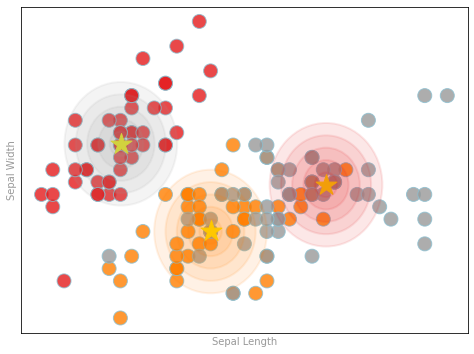

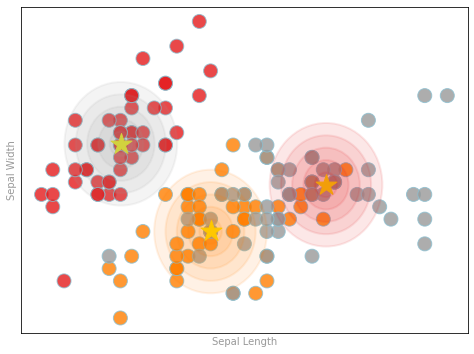

In [335]:
data = irisTwoFeaturesDF.select("features", "label").collect()
features, labels = zip(*data)

x, y = zip(*features)
centers = modelCenters[5]
centroidX, centroidY = zip(*centers)
colorMap = 'Set1'  # was 'Set2', 'Set1', 'Dark2', 'winter'

fig, ax = prepareSubplot(np.arange(-1, 1.1, .4), np.arange(-1, 1.1, .4), figsize=(8,6))
plt.scatter(x, y, s=14**2, c=labels, edgecolors='#8cbfd0', alpha=0.80, cmap=colorMap)
plt.scatter(centroidX, centroidY, s=22**2, marker='*', c='yellow')
cmap = cm.get_cmap(colorMap)

colorIndex = [.5, .99, .0]
for i, (x,y) in enumerate(centers):
    print(cmap(colorIndex[i]))
    for size in [.10, .20, .30, .40, .50]:
        circle1=plt.Circle((x,y),size,color=cmap(colorIndex[i]), alpha=.10, linewidth=2)
        ax.add_artist(circle1)

ax.set_xlabel('Sepal Length'), ax.set_ylabel('Sepal Width');
display(fig);

In addition to seeing the overlay of the clusters at each iteration, we can see how the cluster centers moved with each iteration (and what our results would have looked like if we used fewer iterations).

(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)


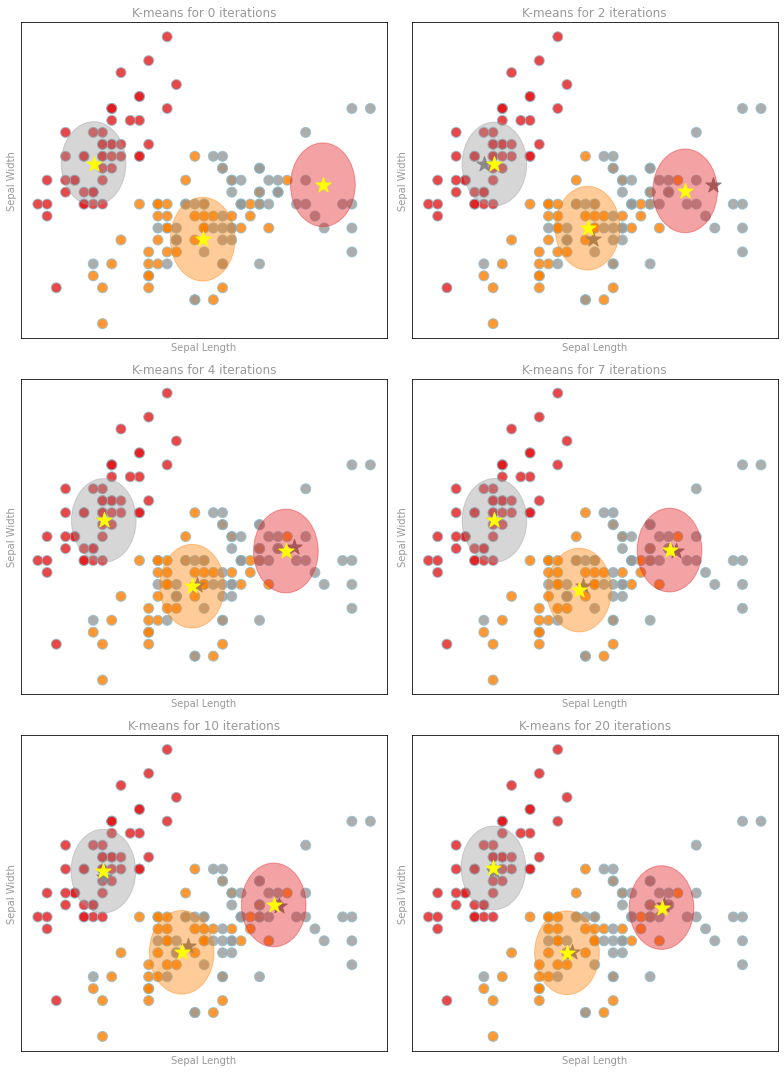

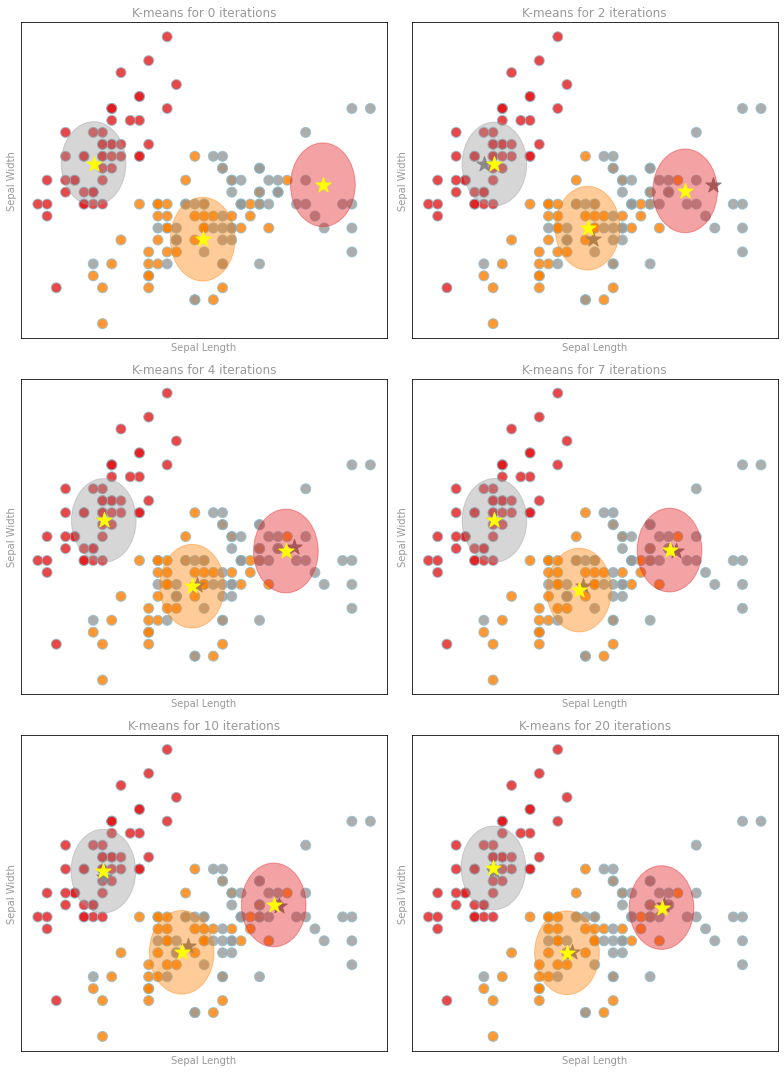

In [336]:
x, y = zip(*features)

oldCentroidX, oldCentroidY = None, None

fig, axList = prepareSubplot(np.arange(-1, 1.1, .4), np.arange(-1, 1.1, .4), figsize=(11, 15),
                             subplots=(3, 2))
axList = axList.flatten()

for i,ax in enumerate(axList[:]):
    ax.set_title('K-means for {0} iterations'.format(iterations[i]), color='#999999')
    centroids = modelCenters[i]
    centroidX, centroidY = zip(*centroids)
    
    ax.scatter(x, y, s=10**2, c=labels, edgecolors='#8cbfd0', alpha=0.80, cmap=colorMap, zorder=0)
    ax.scatter(centroidX, centroidY, s=16**2, marker='*', c='yellow', zorder=2)
    if oldCentroidX and oldCentroidY:
      ax.scatter(oldCentroidX, oldCentroidY, s=16**2, marker='*', c='grey', zorder=1)
    cmap = cm.get_cmap(colorMap)
    
    colorIndex = [.5, .99, 0.]
    for i, (x1,y1) in enumerate(centroids):
      print(cmap(colorIndex[i]))
      circle1=plt.Circle((x1,y1),.35,color=cmap(colorIndex[i]), alpha=.40)
      ax.add_artist(circle1)
    
    ax.set_xlabel('Sepal Length'), ax.set_ylabel('Sepal Width')
    oldCentroidX, oldCentroidY = centroidX, centroidY

plt.tight_layout()

display(fig)